### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


In [2]:
spark = SparkSession.builder.appName('cluster').getOrCreate() 
print('Spark Version: {}'.format(spark.version))

Spark Version: 3.5.1


Load the data into a DataFrame

In [3]:
df = spark.read.csv("C:/Users/Admin/Documents/Emerald/Big Data/Project/Online Retail.csv",header=True,inferSchema=True) 
  


In [4]:
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [5]:
num_rows = df.count()
num_cols = len(df.columns)

print(f'Number of rows and columns in dataframe: ({num_rows}, {num_cols})')

Number of rows and columns in dataframe: (541909, 8)


### Data cleaning and manipulation

In [6]:
# This function written is to counts the number of null values in each column of the DataFrame.
def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

In [7]:
nullcount(df)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 1454,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 135080,
 'Country': 0}

There are lot of missing values in Customer ID column, so we can drop the null value from the dataset, why are we dropping this column? the missing customer ID is a unique number of each customer that carry out a transaction and since this is missing we do not know which of the customer it is and it can not be calculated either.

In [8]:
# Filter out null customer ids
df_new = df.filter(F.col("customerid").isNotNull())

In [9]:
# After the drop the null values
nullcount(df_new)

{'InvoiceNo': 0,
 'StockCode': 0,
 'Description': 0,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 0,
 'Country': 0}

In [10]:
#df_new.toPandas().describe()

###### How many unique customers are present in the dataframe?

In [11]:
df_new.select('customerid').distinct().count()

4372

###### What country do top 10 purchases come from?

In [12]:
from pyspark.sql.functions import *
from pyspark.sql.types import *


# Code Explanation
# - The code uses the groupBy() method to group the data in the DataFrame df by the Country column.
# - The agg() method is then used to apply an aggregation function to each group.
# - In this case, the countDistinct() function is used to count the number of distinct CustomerID values in each group.
# - The alias() method is used to rename the resulting column to country_count.
# - Finally, the show() method is used to display the resulting DataFrame in a tabular format.
# - This will show the number of distinct customers for each country in the Country column of the original DataFrame.

In [13]:
df_new.groupBy('country').agg(countDistinct('customerid').alias('country_count')).show(10)

+------------------+-------------+
|           country|country_count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
+------------------+-------------+
only showing top 10 rows



Notice that the data in the table above isn’t presented in the order of purchases. To sort this table, we can include the orderBy() clause

In [14]:
df_new.groupBy('country').agg(countDistinct('customerid').alias('country_count')).orderBy(desc('country_count')).show(10)

+--------------+-------------+
|       country|country_count|
+--------------+-------------+
|United Kingdom|         3950|
|       Germany|           95|
|        France|           87|
|         Spain|           31|
|       Belgium|           25|
|   Switzerland|           21|
|      Portugal|           19|
|         Italy|           15|
|       Finland|           12|
|       Austria|           11|
+--------------+-------------+
only showing top 10 rows



Most purchases on the platform were made from the United Kingdom.

###### When was the most recent purchase made by a customer on the platform?

To find when the latest purchase was made on the platform, we need to convert the “InvoiceDate” column into a timestamp format and use the max() function in Pyspark:

In [15]:
# latest purchase was made on the platform
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df_new = df_new.withColumn('date', to_timestamp("invoicedate", "mm/dd/yy HH:mm"))
df_new.select(max("date")).alias("LatestPurchase").show()

+-------------------+
|          max(date)|
+-------------------+
|2011-01-31 19:55:00|
+-------------------+



###### When was the earliest purchase made by a customer on the platform?

In [16]:
df_new.select(min("date")).alias("OldestPurchase").show()

+-------------------+
|          min(date)|
+-------------------+
|2010-01-01 08:26:00|
+-------------------+



Our min and max dates are within limits

### Feature Engineering

Now that we have analyzed the dataset and have a better understanding of each data point, we need to prepare the data to feed into the machine learning algorithm.

Let’s take a look at the head of the dataframe once again to understand how the pre-processing will be done

In [17]:
df_new.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-01-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-01-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-01 08:26:00|
+---------+-----

Based on our dataset, our goal is to establish distinct customer segments that reflect individual purchasing patterns.

The current format of the variables in our dataset presents challenges for direct integration into our customer segmentation model. These individual features, as they stand, provide limited insight into customer purchasing behavior.

To address this, we'll leverage the existing variables to create three new, more informative features: recency, frequency, and monetary value (RFM). 

RFM- is commonly used in marketing to evaluate a client’s value based on their:

Recency: How recently has each customer made a purchase?

Frequency: How often have they bought something?

Monetary Value: How much money do they spend on average when making purchases?
    
We will now preprocess the dataframe to create the above variables.

#### Recency

In this step, we focus on understanding how recently a customer has made a purchase. This is a crucial aspect of customer segmentation as it helps in identifying the engagement level of customers. 

This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

i) Assign a recency score to each customer 

In [18]:
df_new = df_new.withColumn("from_date", lit("1/1/10 08:26"))
df_new = df_new.withColumn("from_date", to_timestamp("from_date", 'dd/MM/yy HH:mm'))

df_new.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|

ii) Select the most recent purchase

One customer can make multiple purchases at different times. We need to select only the last time they were seen buying a product, as this is indicative of when the most recent purchase was made:

In [19]:
df_new2 = df_new.withColumn("from_date", to_timestamp(col('from_date'))).withColumn('recency', col("date").cast('long') - col('from_date').cast('long'))
df_new2.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|recency|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+-------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United 

In [20]:
df_new2.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- recency: long (nullable = true)



#### Frequency

Let’s now calculate the value of frequency - how often a customer bought something on the platform. To do this, we just need to group by each customer ID and count the number of items they purchased

In [21]:
df_freq = df_new2.groupBy('customerid').agg(count('invoicedate').alias('frequency'))
df_freq.show(5)

+----------+---------+
|customerid|frequency|
+----------+---------+
|     17420|       30|
|     16861|        8|
|     16503|       86|
|     15727|      302|
|     17389|      224|
+----------+---------+
only showing top 5 rows



This new dataframe only has two columns, and we need to join it with the previous one:

In [22]:
# An inner join returns only the rows that have matching values in both dataframes on the specified column.
df_freq = df_new2.join(df_freq,on='customerid',how='inner')

In [23]:
df_freq.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- recency: long (nullable = true)
 |-- frequency: long (nullable = false)



#### Monetary

Finally, let’s calculate monetary value. There are two steps to achieving this:

*  Calculate monetary value - the total amount spent by each customer in the dataframe
*  step 1: Find the total amount spent in each purchase
*  Each customerID comes with variables called “Quantity” and “UnitPrice” for a single purchase
*  Step 2: Find the total amount spent by each customer
*  Group by the CustomerID column and sum the total amount spent

In [24]:
m_val = df_freq.withColumn("TotalAmount", col("quantity") * col("unitprice"))
m_val.show(5)

+----------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+-------+---------+------------------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|               date|          from_date|recency|frequency|       TotalAmount|
+----------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+-------+---------+------------------+
|     17850|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|      312|15.299999999999999|
|     17850|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|      312|             20.34|
|     17850|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|United Kingdo

In [25]:
m_val = m_val.groupBy('customerid').agg(sum("TotalAmount").alias("monetary"))
m_val.show(5)

+----------+------------------+
|customerid|          monetary|
+----------+------------------+
|     17420| 598.8299999999999|
|     16861|            151.65|
|     16503|           1421.43|
|     15727|           5178.96|
|     17389|31300.079999999994|
+----------+------------------+
only showing top 5 rows



In [26]:
df_final = m_val.join(df_freq, on='customerid', how='inner')
df_final.show(5)

+----------+-----------------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+-------+---------+
|customerid|         monetary|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|               date|          from_date|recency|frequency|
+----------+-----------------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+-------+---------+
|     17850|5288.630000000009|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|      312|
|     17850|5288.630000000009|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|United Kingdom|2010-01-01 08:26:00|2010-01-01 08:26:00|      0|      312|
|     17850|5288.630000000009|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|

Merge this dataframe with the all the other variables:

In [27]:
df_final = df_final.select(['customerid', 'recency', 'frequency', 'monetary']).distinct()
df_final.show(10)

+----------+--------+---------+------------------+
|customerid| recency|frequency|          monetary|
+----------+--------+---------+------------------+
|     17420|    5400|       30| 598.8299999999999|
|     16861|  456180|        8|            151.65|
|     16503| 1142640|       86|           1421.43|
|     15727| 1236060|      302|           5178.96|
|     16503| 1321800|       86|           1421.43|
|     17389|31826760|      224|31300.079999999994|
|     15727|32510400|      302|           5178.96|
|     17389|32512920|      224|31300.079999999994|
|     15447|32583600|        9|            155.17|
|     16503|32587560|       86|           1421.43|
+----------+--------+---------+------------------+
only showing top 10 rows



In [28]:
df_final.count()

22015

In [29]:
# remove zero and negative numbers
rfm_data = (df_final.withColumn("monetary", when(col("monetary") <= 0, 1).otherwise(col("monetary"))))

In [30]:
feat_cols = rfm_data.columns[1:]

#### Standardization

Before building the customer segmentation model, let’s standardize the dataframe to ensure that all the variables are around the same scale:

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# vectorize all features
assemble=VectorAssembler(inputCols=feat_cols, outputCol='features')

assembled_data=assemble.transform(rfm_data)
assembled_data.show(5)


+----------+-------+---------+-----------------+--------------------+
|customerid|recency|frequency|         monetary|            features|
+----------+-------+---------+-----------------+--------------------+
|     17420|   5400|       30|598.8299999999999|[5400.0,30.0,598....|
|     16861| 456180|        8|           151.65|[456180.0,8.0,151...|
|     16503|1142640|       86|          1421.43|[1142640.0,86.0,1...|
|     15727|1236060|      302|          5178.96|[1236060.0,302.0,...|
|     16503|1321800|       86|          1421.43|[1321800.0,86.0,1...|
+----------+-------+---------+-----------------+--------------------+
only showing top 5 rows



In [32]:
# Standardization 
scaler = StandardScaler(inputCol='features', outputCol='standardized', withStd=True, withMean=False)
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)
scaled_data.show(5)

+----------+-------+---------+-----------------+--------------------+--------------------+
|customerid|recency|frequency|         monetary|            features|        standardized|
+----------+-------+---------+-----------------+--------------------+--------------------+
|     17420|   5400|       30|598.8299999999999|[5400.0,30.0,598....|[6.31652343448512...|
|     16861| 456180|        8|           151.65|[456180.0,8.0,151...|[0.05336058630265...|
|     16503|1142640|       86|          1421.43|[1142640.0,86.0,1...|[0.13365763587370...|
|     15727|1236060|      302|          5178.96|[1236060.0,302.0,...|[0.14458522141536...|
|     16503|1321800|       86|          1421.43|[1321800.0,86.0,1...|[0.15461445695745...|
+----------+-------+---------+-----------------+--------------------+--------------------+
only showing top 5 rows



These are the scaled features that will be fed into the clustering algorithm.

#### Model Building

###### Finding number of clusters to build

Now that we have completed all the data analysis and preparation, let’s build the K-Means clustering model.

i) Finding the number of clusters to use

When building a K-Means clustering model, we first need to determine the number of clusters or groups we want the algorithm to return. If we decide on three clusters, for instance, then we will have three customer segments.

The most popular technique used to decide on how many clusters to use in K-Means is called the “elbow-method.”

This is done simply running the K-Means algorithm for a wide range of clusters and visualizing the model results for each cluster. The plot will have an inflection point that looks like an elbow, and we just pick the number of clusters at this point.

Let’s run the following lines of code to build a K-Means clustering algorithm from 2 to 10 clusters:

In [33]:
#Importing the model 
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator

costs = np.zeros(10)
# Apply k-means with different value of k
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('standardized')
    model = kmeans.fit(scaled_data)
    costs[k] = model.summary.trainingCost
    # Print the current value of k and its corresponding cost
    print(f'For k = {k}, the training cost is {costs[k]}')
    

For k = 2, the training cost is 44189.25620382915
For k = 3, the training cost is 18722.963888902792
For k = 4, the training cost is 11094.373965639756
For k = 5, the training cost is 7903.919373716807
For k = 6, the training cost is 6533.0639988359235
For k = 7, the training cost is 5782.209536720679
For k = 8, the training cost is 4348.274567480333
For k = 9, the training cost is 3512.8161486967433


With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 10 clusters. The results have been placed in an array, and can now be visualized in a line chart.

Text(0.5, 1.0, 'Elbow Curve')

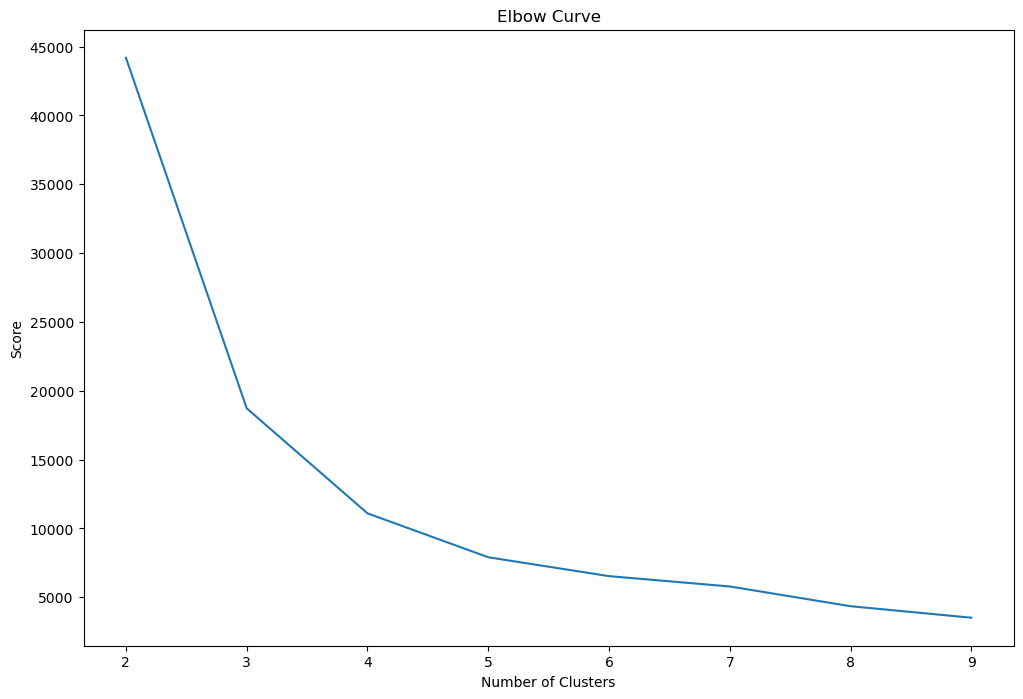

In [34]:
#Visualizing the silhouette scores in a plot 
import matplotlib.pyplot as plt 
  
# Plot the cost
df_cost = pd.DataFrame(costs[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(df_cost.cluster, df_cost.cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Score')
ax.set_title('Elbow Curve')

ii) Building the K-Means Clustering Model

From the plot above, we can see that there is an inflection point that looks like an elbow at four. Due to this, we will proceed to build the K-Means algorithm with four clusters:

In [43]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(scaled_data)

In [44]:
prediction=KMeans_fit.transform(scaled_data)

prediction.show(5)

+----------+-------+---------+-----------------+--------------------+--------------------+----------+
|customerid|recency|frequency|         monetary|            features|        standardized|prediction|
+----------+-------+---------+-----------------+--------------------+--------------------+----------+
|     17420|   5400|       30|598.8299999999999|[5400.0,30.0,598....|[6.31652343448512...|         1|
|     16861| 456180|        8|           151.65|[456180.0,8.0,151...|[0.05336058630265...|         1|
|     16503|1142640|       86|          1421.43|[1142640.0,86.0,1...|[0.13365763587370...|         1|
|     15727|1236060|      302|          5178.96|[1236060.0,302.0,...|[0.14458522141536...|         1|
|     16503|1321800|       86|          1421.43|[1321800.0,86.0,1...|[0.15461445695745...|         1|
+----------+-------+---------+-----------------+--------------------+--------------------+----------+
only showing top 5 rows



#### K Means Clustering

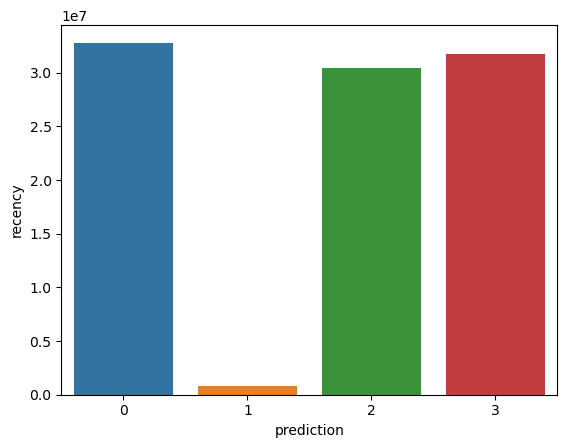

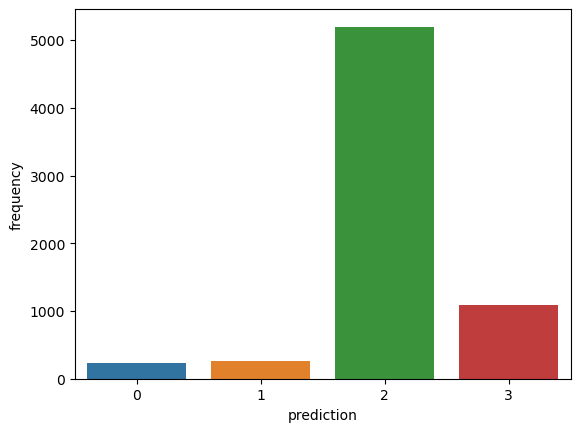

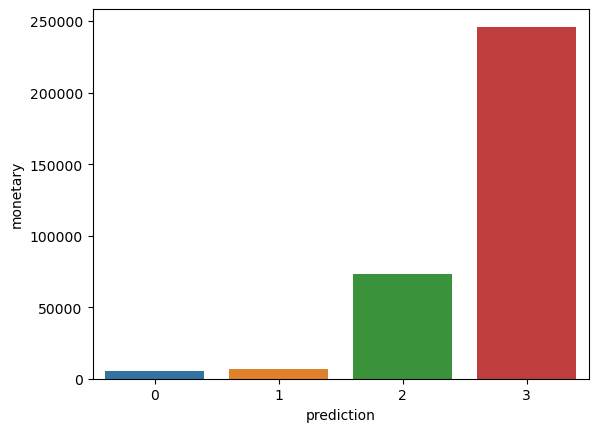

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns


pred_viz = prediction.select('recency','frequency','monetary','prediction')
pred_viz = pred_viz.toPandas()
avg_df = pred_viz.groupby(['prediction'], as_index=False).mean()

rfm_list = ['recency','frequency','monetary']


for i in rfm_list:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Here is an overview of characteristics displayed by customers in each cluster:

**Cluster 0:** This cluster is characterized by high recency and relatively lower frequency and lower monetary values. So these are recent customers who can potentially become long-term customers.<br>
**Cluster 1:** Customers in this cluster tend to spend less. They don’t buy often, and haven't made a purchase recently either. These are likely inactive or low potential customers.<br>
**Cluster 2:** Customers in this cluster tend to high recency and highest monetary. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.<br>
**Cluster 3:** Of all the four clusters, this cluster has the highest recency, moderate frequency, and highest monetary values. Let’s call the customers in this cluster champions (or power shoppers).

In [53]:
spark.stop()